In [286]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix
import xgboost as xgb

In [2]:
df = pd.read_csv('/Users/kate/Downloads/EMS_data.csv')
df

/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,11,17,21,27,28,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
#filter all EMS data to have only cardiac arrest incidents
arrests = df.loc[df['FINAL_CALL_TYPE'] == 'ARREST']
arrests

In [7]:
# arrests.to_csv('arrests_df.csv')

In [328]:
arrests = pd.read_csv('arrests_df.csv', thousands=',')

/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (8,12,18,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [329]:
#clean data

#remove those with invalid times
print(arrests['VALID_DISPATCH_RSPNS_TIME_INDC'].unique())
arrests = arrests[arrests['VALID_INCIDENT_RSPNS_TIME_INDC'].isin(['Y','true','True'])]

#filter arrests for those with disposition "death" (83) or "transport" (82)
print(arrests['INCIDENT_DISPOSITION_CODE'].unique())
arrests = arrests[arrests['INCIDENT_DISPOSITION_CODE'].isin([82,83])]

#drop unnecessary columns
arrests = arrests.drop(['CAD_INCIDENT_ID','INITIAL_SEVERITY_LEVEL_CODE','FINAL_SEVERITY_LEVEL_CODE','VALID_DISPATCH_RSPNS_TIME_INDC','VALID_INCIDENT_RSPNS_TIME_INDC'], axis=1)

#remove null locations, make zipcode the same numeric dtype
arrests = arrests[arrests['ZIPCODE'].notnull()]
pd.to_numeric(arrests['ZIPCODE'], downcast='integer')

arrests

['Y' 'N' 'true' 'false' 'True' True False 'False']
[82. 87. 93. 90. 83. 96. 94. 91. nan 95. 92.]


,Unnamed: 0,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,HELD_INDICATOR,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,REOPEN_INDICATOR,SPECIAL_EVENT_INDICATOR,STANDBY_INDICATOR,TRANSFER_INDICATOR
0,23,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,N,82.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,N,N,N,N
2,291,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,N,82.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,N,N,N,N
3,813,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,N,82.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,N,N,N,N
4,845,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,N,82.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,N,N,N,N
5,973,01/01/2011 05:19:13 AM,RESPIR,ARREST,01/01/2011 05:29:40 AM,627,01/01/2011 05:29:47 AM,01/01/2011 05:33:35 AM,862.0,235.0,01/01/2011 05:42:03 AM,01/01/2011 05:48:06 AM,01/01/2011 06:19:34 AM,Y,82.0,BROOKLYN,K5,11206.0,79.0,36.0,303.0,13.0,8.0,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400139,21792385,05/05/2021 08:04:00 PM,UNC,ARREST,05/05/2021 08:07:00 PM,142,05/05/2021 08:07:00 PM,05/05/2021 08:10:00 PM,351.0,209.0,05/05/2021 08:55:00 PM,05/05/2021 08:59:00 PM,05/05/2021 09:45:00 PM,N,82.0,BRONX,B5,10463.0,50.0,14.0,208.0,10.0,13.0,N,N,N,N
400140,21792426,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,N,82.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,N,N,N,N
400141,21792717,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,N,82.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,N,N,N,N
400143,21792975,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,N,83.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,501.0,31.0,11.0,N,N,N,N


In [330]:
#remove outliers and unreasonable values by observing distribution of each column
arrests['DISPATCH_RESPONSE_SECONDS_QY'].describe()
arrests['INCIDENT_RESPONSE_SECONDS_QY'].describe()
arrests['INCIDENT_TRAVEL_TM_SECONDS_QY'].describe()

arrests.drop(arrests[arrests.DISPATCH_RESPONSE_SECONDS_QY > 100].index, inplace = True)
arrests.drop(arrests[arrests.INCIDENT_RESPONSE_SECONDS_QY > 1000].index, inplace = True)
arrests.drop(arrests[arrests.INCIDENT_TRAVEL_TM_SECONDS_QY > 1000].index, inplace = True)

In [331]:
#feature engineering

arrests.dtypes

Unnamed: 0                         int64
INCIDENT_DATETIME                 object
INITIAL_CALL_TYPE                 object
FINAL_CALL_TYPE                   object
FIRST_ASSIGNMENT_DATETIME         object
DISPATCH_RESPONSE_SECONDS_QY       int64
FIRST_ACTIVATION_DATETIME         object
FIRST_ON_SCENE_DATETIME           object
INCIDENT_RESPONSE_SECONDS_QY     float64
INCIDENT_TRAVEL_TM_SECONDS_QY    float64
FIRST_TO_HOSP_DATETIME            object
FIRST_HOSP_ARRIVAL_DATETIME       object
INCIDENT_CLOSE_DATETIME           object
HELD_INDICATOR                    object
INCIDENT_DISPOSITION_CODE        float64
BOROUGH                           object
INCIDENT_DISPATCH_AREA            object
ZIPCODE                          float64
POLICEPRECINCT                   float64
CITYCOUNCILDISTRICT              float64
COMMUNITYDISTRICT                float64
COMMUNITYSCHOOLDISTRICT          float64
CONGRESSIONALDISTRICT            float64
REOPEN_INDICATOR                  object
SPECIAL_EVENT_IN

In [332]:
#create boolean column for whether the incident started out as a cardiac arrest
arrests["INITIAL_CALL_TYPE=FINAL_CALL_TYPE"] = arrests["INITIAL_CALL_TYPE"] == arrests['FINAL_CALL_TYPE']

#change True/False to 1/0
arrests['INITIAL_CALL_TYPE=FINAL_CALL_TYPE'] = arrests['INITIAL_CALL_TYPE=FINAL_CALL_TYPE'].astype(int)

In [333]:
#keep time columns in same dtype in order to sum
arrests['INCIDENT_RESPONSE_SECONDS_QY'] = arrests['INCIDENT_RESPONSE_SECONDS_QY'].astype(float)
arrests['INCIDENT_TRAVEL_TM_SECONDS_QY'] = arrests['INCIDENT_TRAVEL_TM_SECONDS_QY'].astype(float)
arrests['DISPATCH_RESPONSE_SECONDS_QY'] = arrests['DISPATCH_RESPONSE_SECONDS_QY'].astype(float)

#make column of total call time
arrests['TOTAL_TIME'] = arrests.DISPATCH_RESPONSE_SECONDS_QY + arrests.INCIDENT_RESPONSE_SECONDS_QY + arrests.INCIDENT_TRAVEL_TM_SECONDS_QY

In [334]:
#choose measure of location with fewer unique values for one-hot-encoding
print(arrests['ZIPCODE'].nunique())
print(arrests['POLICEPRECINCT'].nunique())
print(arrests['CITYCOUNCILDISTRICT'].nunique())
print(arrests['COMMUNITYDISTRICT'].nunique())
print(arrests['COMMUNITYSCHOOLDISTRICT'].nunique())
print(arrests['CONGRESSIONALDISTRICT'].nunique())
print(arrests['INCIDENT_DISPATCH_AREA'].nunique())

224
77
51
71
32
13
34


In [335]:
#change incident disposition of death = 0, transport = 1
arrests['INCIDENT_DISPOSITION_CODE'] = arrests['INCIDENT_DISPOSITION_CODE'].replace(83,0)
arrests['INCIDENT_DISPOSITION_CODE'] = arrests['INCIDENT_DISPOSITION_CODE'].replace(82,1)


In [336]:
#determine if these columns provide new info
print(arrests['SPECIAL_EVENT_INDICATOR'].unique())
print(arrests['REOPEN_INDICATOR'].unique())
print(arrests['STANDBY_INDICATOR'].unique())
print(arrests['TRANSFER_INDICATOR'].unique())
print(arrests['HELD_INDICATOR'].unique())

['N' 'false' 'False']
['N' 'Y' 'false' 'true' 'False' 'True']
['N' 'false' 'False']
['N' 'false' 'False']
['N' 'Y' 'false' 'true' 'False' 'True']


In [337]:
#drop unnecessary columns
arrests = arrests.drop(columns=['SPECIAL_EVENT_INDICATOR','REOPEN_INDICATOR','STANDBY_INDICATOR','TRANSFER_INDICATOR','HELD_INDICATOR','Unnamed: 0'], axis=1)

In [338]:
#create month column
datetime = arrests.FIRST_ASSIGNMENT_DATETIME.to_list()
arrests['MONTH'] = [month[0:2] for month in datetime]

In [339]:
#create separate df for tree-based models
tree_df = arrests.copy()
tree_df

,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH
0,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27.0,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,1.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,0,708.0,01
2,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31.0,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,1.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,1,378.0,01
3,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71.0,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,1.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,1,830.0,01
4,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33.0,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,1.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,1,580.0,01
7,01/01/2011 05:22:55 AM,ARREST,ARREST,01/01/2011 05:23:44 AM,49.0,01/01/2011 05:23:49 AM,01/01/2011 05:30:00 AM,425.0,376.0,01/01/2011 05:53:07 AM,01/01/2011 05:59:15 AM,01/01/2011 07:06:45 AM,1.0,QUEENS,Q5,11432.0,107.0,24.0,408.0,26.0,5.0,1,850.0,01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,05/05/2021 07:58:00 PM,ARREST,ARREST,05/05/2021 07:58:00 PM,11.0,05/05/2021 07:58:00 PM,05/05/2021 08:07:00 PM,514.0,503.0,05/05/2021 08:34:00 PM,05/05/2021 08:50:00 PM,05/05/2021 09:22:00 PM,1.0,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,1,1028.0,05
400140,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14.0,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,1.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,0,860.0,05
400141,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20.0,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,1.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,1,426.0,05
400143,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25.0,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,0.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,501.0,31.0,11.0,1,368.0,05


In [340]:
#create dummy variables to represent borough as numeric
dummy = pd.get_dummies(arrests['BOROUGH'])
arrests = pd.concat([arrests,dummy], axis=1)
arrests = arrests.drop('RICHMOND / STATEN ISLAND',axis=1)
arrests

,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,BRONX,BROOKLYN,MANHATTAN,QUEENS
0,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27.0,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,1.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,0,708.0,01,0,1,0,0
2,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31.0,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,1.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,1,378.0,01,1,0,0,0
3,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71.0,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,1.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,1,830.0,01,1,0,0,0
4,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33.0,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,1.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,1,580.0,01,0,1,0,0
7,01/01/2011 05:22:55 AM,ARREST,ARREST,01/01/2011 05:23:44 AM,49.0,01/01/2011 05:23:49 AM,01/01/2011 05:30:00 AM,425.0,376.0,01/01/2011 05:53:07 AM,01/01/2011 05:59:15 AM,01/01/2011 07:06:45 AM,1.0,QUEENS,Q5,11432.0,107.0,24.0,408.0,26.0,5.0,1,850.0,01,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,05/05/2021 07:58:00 PM,ARREST,ARREST,05/05/2021 07:58:00 PM,11.0,05/05/2021 07:58:00 PM,05/05/2021 08:07:00 PM,514.0,503.0,05/05/2021 08:34:00 PM,05/05/2021 08:50:00 PM,05/05/2021 09:22:00 PM,1.0,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,1,1028.0,05,1,0,0,0
400140,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14.0,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,1.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,0,860.0,05,0,0,0,1
400141,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20.0,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,1.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,1,426.0,05,0,1,0,0
400143,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25.0,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,0.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,501.0,31.0,11.0,1,368.0,05,0,0,0,0


In [341]:
#change month number to name of month
arrests['MONTH'] = pd.to_datetime(arrests['MONTH'], format='%m').dt.month_name().str.slice(stop=3)
arrests

,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,BRONX,BROOKLYN,MANHATTAN,QUEENS
0,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27.0,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,1.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,0,708.0,Jan,0,1,0,0
2,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31.0,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,1.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,1,378.0,Jan,1,0,0,0
3,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71.0,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,1.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,1,830.0,Jan,1,0,0,0
4,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33.0,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,1.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,1,580.0,Jan,0,1,0,0
7,01/01/2011 05:22:55 AM,ARREST,ARREST,01/01/2011 05:23:44 AM,49.0,01/01/2011 05:23:49 AM,01/01/2011 05:30:00 AM,425.0,376.0,01/01/2011 05:53:07 AM,01/01/2011 05:59:15 AM,01/01/2011 07:06:45 AM,1.0,QUEENS,Q5,11432.0,107.0,24.0,408.0,26.0,5.0,1,850.0,Jan,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,05/05/2021 07:58:00 PM,ARREST,ARREST,05/05/2021 07:58:00 PM,11.0,05/05/2021 07:58:00 PM,05/05/2021 08:07:00 PM,514.0,503.0,05/05/2021 08:34:00 PM,05/05/2021 08:50:00 PM,05/05/2021 09:22:00 PM,1.0,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,1,1028.0,May,1,0,0,0
400140,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14.0,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,1.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,0,860.0,May,0,0,0,1
400141,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20.0,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,1.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,1,426.0,May,0,1,0,0
400143,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25.0,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,0.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,501.0,31.0,11.0,1,368.0,May,0,0,0,0


In [342]:
#create dummy variables to represent month category as numeric
dummy2 = pd.get_dummies(arrests['MONTH'])
arrests = pd.concat([arrests,dummy2], axis=1)
arrests = arrests.drop('Dec',axis=1)
arrests

,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,BRONX,BROOKLYN,MANHATTAN,QUEENS,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27.0,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,1.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,0,708.0,Jan,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31.0,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,1.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,1,378.0,Jan,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71.0,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,1.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,1,830.0,Jan,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33.0,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,1.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,1,580.0,Jan,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,01/01/2011 05:22:55 AM,ARREST,ARREST,01/01/2011 05:23:44 AM,49.0,01/01/2011 05:23:49 AM,01/01/2011 05:30:00 AM,425.0,376.0,01/01/2011 05:53:07 AM,01/01/2011 05:59:15 AM,01/01/2011 07:06:45 AM,1.0,QUEENS,Q5,11432.0,107.0,24.0,408.0,26.0,5.0,1,850.0,Jan,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,05/05/2021 07:58:00 PM,ARREST,ARREST,05/05/2021 07:58:00 PM,11.0,05/05/2021 07:58:00 PM,05/05/2021 08:07:00 PM,514.0,503.0,05/05/2021 08:34:00 PM,05/05/2021 08:50:00 PM,05/05/2021 09:22:00 PM,1.0,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,1,1028.0,May,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
400140,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14.0,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,1.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,0,860.0,May,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
400141,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20.0,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,1.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,1,426.0,May,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
400143,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25.0,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,0.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,501.0,31.0,11.0,1,368.0,May,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [343]:
#create dummy variables to represent dispatch area as numeric
dummy3 = pd.get_dummies(arrests['INCIDENT_DISPATCH_AREA'], drop_first=True)
arrests = pd.concat([arrests,dummy3], axis=1)
arrests

,INCIDENT_DATETIME,INITIAL_CALL_TYPE,FINAL_CALL_TYPE,FIRST_ASSIGNMENT_DATETIME,DISPATCH_RESPONSE_SECONDS_QY,FIRST_ACTIVATION_DATETIME,FIRST_ON_SCENE_DATETIME,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,FIRST_TO_HOSP_DATETIME,FIRST_HOSP_ARRIVAL_DATETIME,INCIDENT_CLOSE_DATETIME,INCIDENT_DISPOSITION_CODE,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,BRONX,BROOKLYN,MANHATTAN,QUEENS,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,B2,B3,B4,B5,CW,K1,K2,K3,K4,K5,K6,K7,M1,M2,M3,M4,M5,M6,M7,M8,M9,Q1,Q2,Q3,Q4,Q5,Q6,Q7,S1,S2,S3,X1,X2
0,01/01/2011 02:22:24 AM,DRUG,ARREST,01/01/2011 02:22:51 AM,27.0,01/01/2011 02:22:58 AM,01/01/2011 02:28:18 AM,354.0,327.0,01/01/2011 02:52:07 AM,01/01/2011 03:07:10 AM,01/01/2011 03:46:17 AM,1.0,BROOKLYN,K7,11206.0,90.0,34.0,301.0,14.0,7.0,0,708.0,Jan,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,01/01/2011 03:09:10 AM,ARREST,ARREST,01/01/2011 03:09:41 AM,31.0,01/01/2011 03:10:17 AM,01/01/2011 03:12:19 AM,189.0,158.0,01/01/2011 03:27:29 AM,01/01/2011 03:33:34 AM,01/01/2011 04:30:39 AM,1.0,BRONX,B1,10454.0,40.0,8.0,201.0,7.0,15.0,1,378.0,Jan,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,01/01/2011 04:43:00 AM,ARREST,ARREST,01/01/2011 04:44:11 AM,71.0,01/01/2011 04:44:27 AM,01/01/2011 04:49:55 AM,415.0,344.0,01/01/2011 05:58:41 AM,01/01/2011 06:04:37 AM,01/01/2011 06:36:11 AM,1.0,BRONX,B1,10456.0,42.0,16.0,203.0,9.0,15.0,1,830.0,Jan,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,01/01/2011 04:50:32 AM,ARREST,ARREST,01/01/2011 04:51:05 AM,33.0,01/01/2011 04:51:14 AM,01/01/2011 04:55:22 AM,290.0,257.0,01/01/2011 05:05:21 AM,01/01/2011 05:09:06 AM,01/01/2011 05:56:46 AM,1.0,BROOKLYN,K2,11218.0,66.0,39.0,312.0,15.0,7.0,1,580.0,Jan,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,01/01/2011 05:22:55 AM,ARREST,ARREST,01/01/2011 05:23:44 AM,49.0,01/01/2011 05:23:49 AM,01/01/2011 05:30:00 AM,425.0,376.0,01/01/2011 05:53:07 AM,01/01/2011 05:59:15 AM,01/01/2011 07:06:45 AM,1.0,QUEENS,Q5,11432.0,107.0,24.0,408.0,26.0,5.0,1,850.0,Jan,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,05/05/2021 07:58:00 PM,ARREST,ARREST,05/05/2021 07:58:00 PM,11.0,05/05/2021 07:58:00 PM,05/05/2021 08:07:00 PM,514.0,503.0,05/05/2021 08:34:00 PM,05/05/2021 08:50:00 PM,05/05/2021 09:22:00 PM,1.0,BRONX,B4,10466.0,47.0,12.0,212.0,11.0,16.0,1,1028.0,May,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400140,05/05/2021 08:19:00 PM,STATEP,ARREST,05/05/2021 08:20:00 PM,14.0,05/05/2021 08:20:00 PM,05/05/2021 08:26:00 PM,430.0,416.0,05/05/2021 09:11:00 PM,05/05/2021 09:20:00 PM,05/05/2021 09:53:00 PM,1.0,QUEENS,Q7,11362.0,111.0,19.0,411.0,26.0,3.0,0,860.0,May,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
400141,05/05/2021 09:51:00 PM,ARREST,ARREST,05/05/2021 09:52:00 PM,20.0,05/05/2021 09:52:00 PM,05/05/2021 09:55:00 PM,213.0,193.0,05/05/2021 10:32:00 PM,05/05/2021 10:39:00 PM,05/05/2021 11:16:00 PM,1.0,BROOKLYN,K1,11214.0,60.0,47.0,313.0,21.0,11.0,1,426.0,May,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400143,05/05/2021 11:30:00 PM,ARREST,ARREST,05/05/2021 11:30:00 PM,25.0,05/05/2021 11:30:00 PM,05/05/2021 11:33:00 PM,184.0,159.0,NaN,NaN,05/06/2021 12:00:00 AM,0.0,RICHMOND / STATEN ISLAND,S1,10301.0,120.0,49.0,50

In [344]:
#create new df of only numeric columns to use in log reg model
arrests_num = arrests.drop(columns=['INCIDENT_DATETIME','INITIAL_CALL_TYPE','FINAL_CALL_TYPE','FIRST_ASSIGNMENT_DATETIME','FIRST_ACTIVATION_DATETIME','FIRST_ON_SCENE_DATETIME','FIRST_TO_HOSP_DATETIME','FIRST_HOSP_ARRIVAL_DATETIME','INCIDENT_CLOSE_DATETIME','BOROUGH','INCIDENT_DISPATCH_AREA','ZIPCODE','POLICEPRECINCT','CITYCOUNCILDISTRICT','COMMUNITYDISTRICT','COMMUNITYSCHOOLDISTRICT','CONGRESSIONALDISTRICT','MONTH'], axis=1)
arrests_num

,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INCIDENT_DISPOSITION_CODE,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,BRONX,BROOKLYN,MANHATTAN,QUEENS,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,B2,B3,B4,B5,CW,K1,K2,K3,K4,K5,K6,K7,M1,M2,M3,M4,M5,M6,M7,M8,M9,Q1,Q2,Q3,Q4,Q5,Q6,Q7,S1,S2,S3,X1,X2
0,27.0,354.0,327.0,1.0,0,708.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,31.0,189.0,158.0,1.0,1,378.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,71.0,415.0,344.0,1.0,1,830.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,33.0,290.0,257.0,1.0,1,580.0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,49.0,425.0,376.0,1.0,1,850.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400138,11.0,514.0,503.0,1.0,1,1028.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400140,14.0,430.0,416.0,1.0,0,860.0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
400141,20.0,213.0,193.0,1.0,1,426.0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400143,25.0,184.0,159.0,0.0,1,368.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [345]:
#Prepare for initial models

X = arrests_num.drop('INCIDENT_DISPOSITION_CODE',axis=1)
y = arrests_num.INCIDENT_DISPOSITION_CODE

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = 0.2, random_state=2)

train_df = X_train.copy()
train_df['INCIDENT_DISPOSITION_CODE'] = y_train
train_df

,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,BRONX,BROOKLYN,MANHATTAN,QUEENS,Apr,Aug,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,B2,B3,B4,B5,CW,K1,K2,K3,K4,K5,K6,K7,M1,M2,M3,M4,M5,M6,M7,M8,M9,Q1,Q2,Q3,Q4,Q5,Q6,Q7,S1,S2,S3,X1,X2,INCIDENT_DISPOSITION_CODE
148573,21.0,374.0,353.0,1,748.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
311616,89.0,393.0,304.0,0,786.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1.0
332117,16.0,246.0,230.0,1,492.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
114774,15.0,145.0,130.0,1,290.0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.0
56229,14.0,342.0,328.0,0,684.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296423,49.0,452.0,403.0,0,904.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
399253,15.0,398.0,383.0,0,796.0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0
66839,21.0,469.0,448.0,1,938.0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0
199572,21.0,165.0,144.0,1,330.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0


In [346]:
#initial KNN model had accuracy score of 0.55153
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)

print(metrics.accuracy_score(y_val, y_pred))

0.5462807278918804


In [347]:
lm1 = LogisticRegression(C=1000) # setting C very high essentially removes regularization
lm1.fit(X_train, y_train)

/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1000)

In [363]:
#logistic regression model
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_val_scaled = std_scale.fit_transform(X_val)
X_test_scaled = std_scale.fit_transform(X_test)

lm4 = LogisticRegression()
lm4.fit(X_train_scaled, y_train)

y_pred = lm4.predict(X_val_scaled) 
print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
          (metrics.accuracy_score(y_val,y_pred),
          metrics.precision_score(y_val,y_pred),
          metrics.recall_score(y_val,y_pred),
          metrics.f1_score(y_val,y_pred))
     )
      

Logistic regression validation metrics: 
 Accuracy: 0.6197 
 Precision: 0.6656 
 Recall: 0.6829 
 F1: 0.6741


In [351]:
#10 nearest neighbors
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_val)
print('Logistic regression validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
          (metrics.accuracy_score(y_val,y_pred),
          metrics.precision_score(y_val,y_pred),
          metrics.recall_score(y_val,y_pred),
          metrics.f1_score(y_val,y_pred))
     )

Logistic regression validation metrics: 
 Accuracy: 0.6269 
 Precision: 0.6559 
 Recall: 0.7408 
 F1: 0.6958


In [353]:
#Bernoulli Naive Bayes
nb = BernoulliNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_val)
print('Bernoulli Naive Bayes validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
          (metrics.accuracy_score(y_val,y_pred),
          metrics.precision_score(y_val,y_pred),
          metrics.recall_score(y_val,y_pred),
          metrics.f1_score(y_val,y_pred))
     )

Bernoulli Naive Bayes validation metrics: 
 Accuracy: 0.6140 
 Precision: 0.6588 
 Recall: 0.6840 
 F1: 0.6712


In [354]:
#tree models

#instead of one-hot-encoding, use labels for categorical features
tree_df = tree_df.drop(columns=['INCIDENT_DATETIME','INITIAL_CALL_TYPE','FINAL_CALL_TYPE','FIRST_ASSIGNMENT_DATETIME','FIRST_ACTIVATION_DATETIME','FIRST_ON_SCENE_DATETIME','FIRST_TO_HOSP_DATETIME','FIRST_HOSP_ARRIVAL_DATETIME','INCIDENT_CLOSE_DATETIME'], axis=1)

tree_df['BOROUGH'] = OrdinalEncoder().fit_transform(tree_df[['BOROUGH']])
tree_df['INCIDENT_DISPATCH_AREA'] = OrdinalEncoder().fit_transform(tree_df[['INCIDENT_DISPATCH_AREA']])

In [355]:
tree_df['MONTH'] = tree_df['MONTH'].astype(int)

In [356]:
tree_df = tree_df.fillna(0)
#tree_df = tree_df.drop(columns=['level_0','index'],axis=1)

In [357]:
#Decision Tree model

X2 = tree_df.drop('INCIDENT_DISPOSITION_CODE',axis=1)
y2 = tree_df.INCIDENT_DISPOSITION_CODE

X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2, test_size = 0.2, random_state=42)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train,y2_train, test_size = 0.2, random_state=2)

train_df2 = X2_train.copy()
train_df2['INCIDENT_DISPOSITION_CODE'] = y2_train
train_df2

,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,INCIDENT_DISPOSITION_CODE
148573,21.0,374.0,353.0,3.0,25.0,11375.0,112.0,29.0,406.0,28.0,6.0,1,748.0,12,0.0
311616,89.0,393.0,304.0,3.0,22.0,11691.0,101.0,31.0,414.0,27.0,5.0,0,786.0,1,1.0
332117,16.0,246.0,230.0,2.0,17.0,10021.0,19.0,4.0,108.0,2.0,12.0,1,492.0,12,0.0
114774,15.0,145.0,130.0,2.0,21.0,10031.0,30.0,7.0,109.0,6.0,13.0,1,290.0,11,1.0
56229,14.0,342.0,328.0,2.0,16.0,10025.0,24.0,6.0,107.0,3.0,10.0,0,684.0,8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296423,49.0,452.0,403.0,1.0,9.0,11239.0,75.0,42.0,318.0,19.0,8.0,0,904.0,3,0.0
399253,15.0,398.0,383.0,0.0,0.0,10456.0,42.0,16.0,203.0,9.0,15.0,0,796.0,4,1.0
66839,21.0,469.0,448.0,3.0,25.0,11374.0,112.0,29.0,406.0,28.0,6.0,1,938.0,1,0.0
199572,21.0,165.0,144.0,0.0,2.0,10461.0,49.0,13.0,211.0,11.0,14.0,1,330.0,5,1.0


In [358]:
train_df2.replace([np.inf, -np.inf], np.nan)
train_df2 = train_df2.dropna()
train_df2

,DISPATCH_RESPONSE_SECONDS_QY,INCIDENT_RESPONSE_SECONDS_QY,INCIDENT_TRAVEL_TM_SECONDS_QY,BOROUGH,INCIDENT_DISPATCH_AREA,ZIPCODE,POLICEPRECINCT,CITYCOUNCILDISTRICT,COMMUNITYDISTRICT,COMMUNITYSCHOOLDISTRICT,CONGRESSIONALDISTRICT,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,TOTAL_TIME,MONTH,INCIDENT_DISPOSITION_CODE
148573,21.0,374.0,353.0,3.0,25.0,11375.0,112.0,29.0,406.0,28.0,6.0,1,748.0,12,0.0
311616,89.0,393.0,304.0,3.0,22.0,11691.0,101.0,31.0,414.0,27.0,5.0,0,786.0,1,1.0
332117,16.0,246.0,230.0,2.0,17.0,10021.0,19.0,4.0,108.0,2.0,12.0,1,492.0,12,0.0
114774,15.0,145.0,130.0,2.0,21.0,10031.0,30.0,7.0,109.0,6.0,13.0,1,290.0,11,1.0
56229,14.0,342.0,328.0,2.0,16.0,10025.0,24.0,6.0,107.0,3.0,10.0,0,684.0,8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296423,49.0,452.0,403.0,1.0,9.0,11239.0,75.0,42.0,318.0,19.0,8.0,0,904.0,3,0.0
399253,15.0,398.0,383.0,0.0,0.0,10456.0,42.0,16.0,203.0,9.0,15.0,0,796.0,4,1.0
66839,21.0,469.0,448.0,3.0,25.0,11374.0,112.0,29.0,406.0,28.0,6.0,1,938.0,1,0.0
199572,21.0,165.0,144.0,0.0,2.0,10461.0,49.0,13.0,211.0,11.0,14.0,1,330.0,5,1.0


In [359]:
train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 187939 entries, 148573 to 346505
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   DISPATCH_RESPONSE_SECONDS_QY       187939 non-null  float64
 1   INCIDENT_RESPONSE_SECONDS_QY       187939 non-null  float64
 2   INCIDENT_TRAVEL_TM_SECONDS_QY      187939 non-null  float64
 3   BOROUGH                            187939 non-null  float64
 4   INCIDENT_DISPATCH_AREA             187939 non-null  float64
 5   ZIPCODE                            187939 non-null  float64
 6   POLICEPRECINCT                     187939 non-null  float64
 7   CITYCOUNCILDISTRICT                187939 non-null  float64
 8   COMMUNITYDISTRICT                  187939 non-null  float64
 9   COMMUNITYSCHOOLDISTRICT            187939 non-null  float64
 10  CONGRESSIONALDISTRICT              187939 non-null  float64
 11  INITIAL_CALL_TYPE=FINAL_CALL_TYPE 

In [360]:
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X2_train,y2_train)

y2_pred = dt.predict(X2_val)
print('Decision Tree validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
          (metrics.accuracy_score(y2_val,y2_pred),
          metrics.precision_score(y2_val,y2_pred),
          metrics.recall_score(y2_val,y2_pred),
          metrics.f1_score(y2_val,y2_pred))
     )
      

Decision Tree validation metrics: 
 Accuracy: 0.5530 
 Precision: 0.6129 
 Recall: 0.6080 
 F1: 0.6104


In [361]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X2_train,y2_train)

y2_pred = rf.predict(X2_val)
print('Random Forest validation metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f' %
          (metrics.accuracy_score(y2_val,y2_pred),
          metrics.precision_score(y2_val,y2_pred),
          metrics.recall_score(y2_val,y2_pred),
          metrics.f1_score(y2_val,y2_pred))
     )
      

Random Forest validation metrics: 
 Accuracy: 0.6030 
 Precision: 0.6441 
 Recall: 0.6943 
 F1: 0.6683


In [364]:
#XGBoost

gbm = xgb.XGBRegressor( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="reg:squarederror",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

eval_set=[(X2_train,y2_train),(X2_val,y2_val)] #tracking train/validation error as we go
fit_model = gbm.fit( 
                    X2_train, y2_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=20,
                    verbose=False
                   )

In [ ]:
#false positive: death labeled transport
#false negative: transport labeled death
#true positive: transport
#true negative: death


In [368]:
y_pred = lm4.predict(X_test_scaled) 
print('Test Metrics: \n Logistic regression: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC AUC: %.4f' %
          (metrics.accuracy_score(y_test,y_pred),
          metrics.precision_score(y_test,y_pred),
          metrics.recall_score(y_test,y_pred),
          metrics.f1_score(y_test,y_pred),
          metrics.roc_auc_score(y_test,y_pred))
     )

y_pred = knn.predict(X_test)
print('10 Nearest Neighbors: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC AUC: %.4f' %
          (metrics.accuracy_score(y_test,y_pred),
          metrics.precision_score(y_test,y_pred),
          metrics.recall_score(y_test,y_pred),
          metrics.f1_score(y_test,y_pred),
          metrics.roc_auc_score(y_test,y_pred))
     )

y_pred = nb.predict(X_test)
print('Bernoulli Naive Bayes: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC AUC: %.4f' %
          (metrics.accuracy_score(y_test,y_pred),
          metrics.precision_score(y_test,y_pred),
          metrics.recall_score(y_test,y_pred),
          metrics.f1_score(y_test,y_pred),
          metrics.roc_auc_score(y_test,y_pred))
     )

y_pred = dt.predict(X2_test)
print('Decision Tree: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC AUC: %.4f' %
          (metrics.accuracy_score(y2_test,y_pred),
          metrics.precision_score(y2_test,y_pred),
          metrics.recall_score(y2_test,y_pred),
          metrics.f1_score(y2_test,y_pred),
          metrics.roc_auc_score(y_test,y_pred))
     )

y_pred = rf.predict(X2_test)
print('Random Forest: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n ROC AUC: %.4f' %
          (metrics.accuracy_score(y2_test,y_pred),
          metrics.precision_score(y2_test,y_pred),
          metrics.recall_score(y2_test,y_pred),
          metrics.f1_score(y2_test,y_pred),
          metrics.roc_auc_score(y_test,y_pred))
     )

Test Metrics: 
 Logistic regression: 
 Accuracy: 0.6180 
 Precision: 0.6651 
 Recall: 0.6804 
 F1: 0.6727 
 ROC AUC: 0.6066
10 Nearest Neighbors: 
 Accuracy: 0.5492 
 Precision: 0.5957 
 Recall: 0.6808 
 F1: 0.6354 
 ROC AUC: 0.5253
Bernoulli Naive Bayes: 
 Accuracy: 0.6148 
 Precision: 0.6597 
 Recall: 0.6865 
 F1: 0.6728 
 ROC AUC: 0.6018
Decision Tree: 
 Accuracy: 0.5538 
 Precision: 0.6140 
 Recall: 0.6106 
 F1: 0.6123 
 ROC AUC: 0.5435
Random Forest: 
 Accuracy: 0.6001 
 Precision: 0.6433 
 Recall: 0.6885 
 F1: 0.6652 
 ROC AUC: 0.5840


/Users/kate/opt/anaconda3/envs/metis/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'F1 Score')

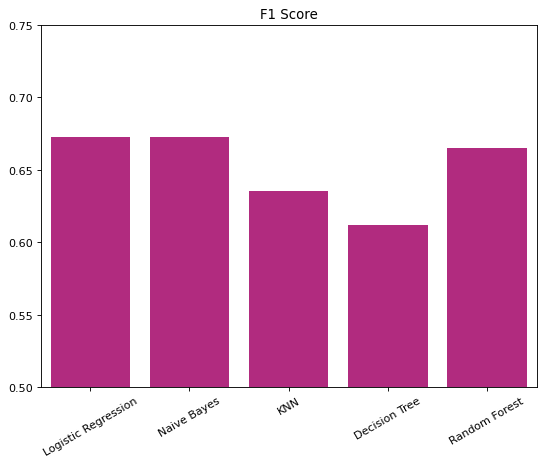

In [396]:
x_plot = ['Logistic Regression','Naive Bayes','KNN','Decision Tree','Random Forest']
y_plot = [0.6727,0.6728,0.6354,0.6123,0.6652]
figure(figsize=(8, 6), dpi=80)
sns.barplot(x_plot,y_plot,color='mediumvioletred')
plt.ylim(0.5,0.75)
plt.xticks(rotation=30)
plt.title('F1 Score')

In [369]:
rf.feature_importances_

array([0.15569827, 0.15250137, 0.16805369, 0.00114791, 0.01783893,
       0.0594841 , 0.02763567, 0.03311637, 0.02413779, 0.02076195,
       0.01621861, 0.06806221, 0.15221482, 0.10312831])

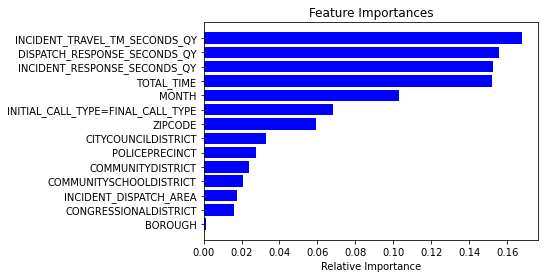

In [370]:
features = X2.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [371]:
coefficients = pd.DataFrame(
    {'Feature': X.columns,
     'Coefficient': lm3.coef_[0]
    })
coefficients.sort_values('Coefficient')

,Feature,Coefficient
3,INITIAL_CALL_TYPE=FINAL_CALL_TYPE,-0.608535
36,M5,-0.284161
35,M4,-0.280901
33,M2,-0.259478
25,K1,-0.236517
40,M9,-0.234226
32,M1,-0.219733
8,QUEENS,-0.207817
39,M8,-0.189570
34,M3,-0.184951


In [372]:
coef_sorted = coefficients.sort_values('Coefficient').reset_index()

In [373]:
indices = (0,7,14,28,33,34,35,36,37,40,41,44,45,46,47,48,49,50,52)

df_coef = coef_sorted.loc[[i for i in indices]]

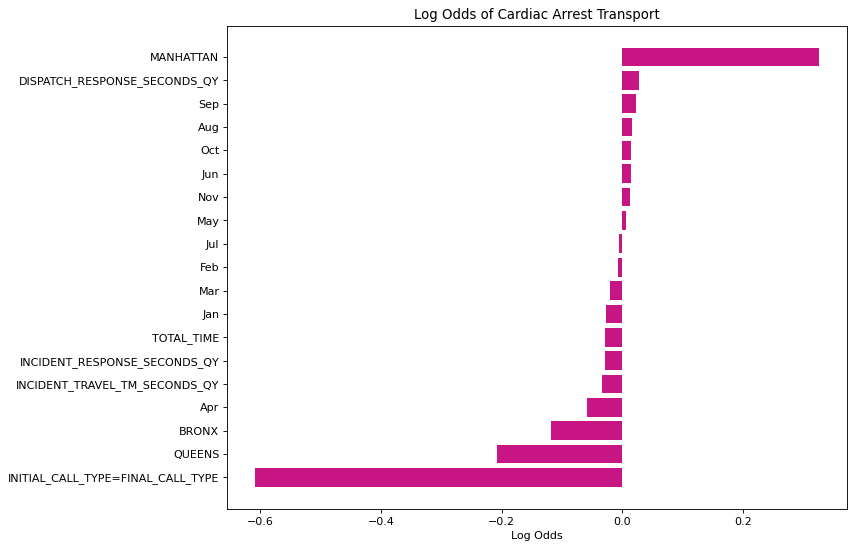

In [374]:
from matplotlib.pyplot import figure

indices = [i for i in df_coef['Coefficient']]

figure(figsize=(10, 8), dpi=80)
plt.title('Log Odds of Cardiac Arrest Transport')
plt.barh(df_coef['Feature'], df_coef['Coefficient'], color='mediumvioletred', align='center')
#plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Log Odds')

plt.show()

In [375]:
import statsmodels.api as sm

sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     INCIDENT_DISPOSITION_CODE   R-squared (uncentered):                   0.612
Model:                                   OLS   Adj. R-squared (uncentered):              0.612
Method:                        Least Squares   F-statistic:                              9097.
Date:                       Thu, 24 Feb 2022   Prob (F-statistic):                        0.00
Time:                               15:34:49   Log-Likelihood:                     -1.9696e+05
No. Observations:                     293655   AIC:                                  3.940e+05
Df Residuals:                         293604   BIC:                                  3.946e+05
Df Model:                                 51                                                  
Covariance Type:                   nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
DISPATCH_RESPONSE_SECONDS_QY          0.0002   2.92e-05      6.615      0.000       0.000       0.000
INCIDENT_RESPONSE_SECONDS_QY       9.928e-06   4.82e-06      2.060      0.039    4.81e-07    1.94e-05
INCIDENT_TRAVEL_TM_SECONDS_QY        -0.0002   2.45e-05     -7.471      0.000      -0.000      -0.000
INITIAL_CALL_TYPE=FINAL_CALL_TYPE    -0.2889      0.002   -147.273      0.000      -0.293      -0.285
TOTAL_TIME                         1.986e-05   9.64e-06      2.060      0.039    9.62e-07    3.88e-05
BRONX                                 0.8902      0.006    144.076      0.000       0.878       0.902
BROOKLYN                              0.7208      0.075      9.556      0.000       0.573       0.869
MANHATTAN                             0.8350      0.076     10.931      0.000       0.685       0.985
QUEENS                                0.5690      0.078      7.308      0.000       0.416       0.722
Apr                                  -0.0461      0.004    -11.319      0.000      -0.054      -0.038
Aug                                   0.0154      0.004      3.576      0.000       0.007       0.024
Feb                                  -0.0097      0.004     -2.301      0.021      -0.018      -0.001
Jan                                  -0.0184      0.004     -4.510      0.000      -0.026      -0.010
Jul                                   0.0004      0.004      0.083      0.934      -0.008       0.009
Jun                                   0.0126      0.004      2.936      0.003       0.004       0.021
Mar                                  -0.0151      0.004     -3.653      0.000      -0.023      -0.007
May                                   0.0070      0.004      1.658      0.097      -0.001       0.015
Nov                                   0.0093      0.004      2.235      0.025       0.001       0.017
Oct                                   0.0115      0.004      2.725      0.006       0.003       0.020
Sep                                   0.0165      0.004      3.805      0.000       0.008       0.025
B2                                   -0.0204      0.006     -3.351      0.001      -0.032      -0.008
B3                                   -0.0761      0.006    -12.189      0.000      -0.088      -0.064
B4                                   -0.1038      0.007    -15.460      0.000      -0.117      -0.091
B5                                   -0.1095      0.007    -16.558      0.000      -0.123      -0.097
CW                                    0.6726      0.479      1.404      0.160      -0.267       1.612
K1                                    0.0238      0

In [376]:
# create a helper function for plotting feature(s) vs target variable 

def plot_features(tree_df,sample_size=500):
    
    sample = (tree_df.sample(1000, random_state=44)) 
    sns.pairplot(sample,hue='INCIDENT_DISPOSITION_CODE', plot_kws=dict(alpha=.3, edgecolor='none'))

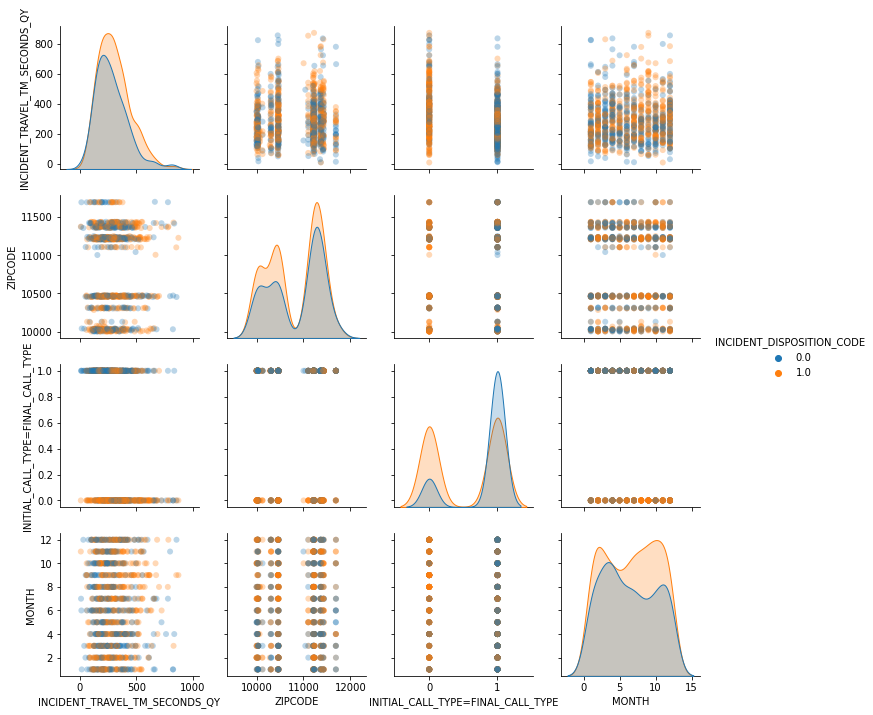

In [378]:
plot_features(tree_df[['INCIDENT_TRAVEL_TM_SECONDS_QY','ZIPCODE','INITIAL_CALL_TYPE=FINAL_CALL_TYPE','MONTH','INCIDENT_DISPOSITION_CODE']])



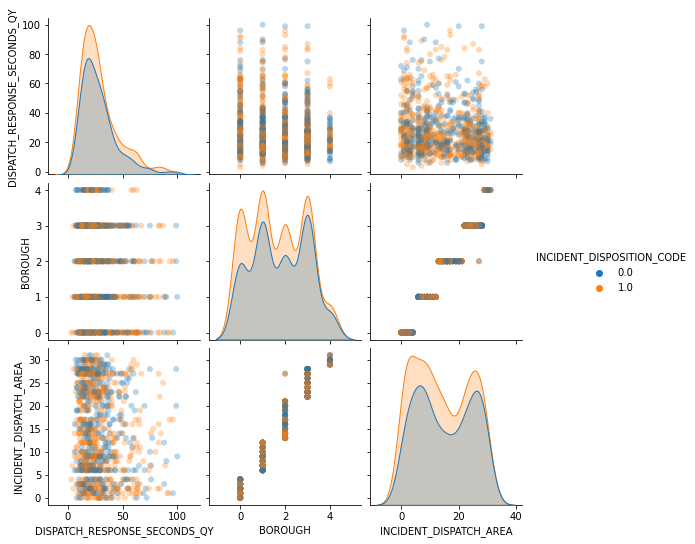

In [379]:
plot_features(tree_df[['DISPATCH_RESPONSE_SECONDS_QY','BOROUGH','INCIDENT_DISPATCH_AREA','INCIDENT_DISPOSITION_CODE']])

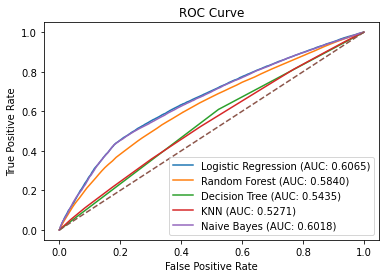

In [382]:
fpr, tpr, _ = roc_curve(y_test, lm4.predict_proba(X_test_scaled)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X2_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, dt.predict_proba(X2_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, nb.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)


plt.plot(x, x, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['Logistic Regression (AUC: 0.6065)','Random Forest (AUC: 0.5840)','Decision Tree (AUC: 0.5435)', 'KNN (AUC: 0.5271)', 'Naive Bayes (AUC: 0.6018)'])